### Customer Segmentation Using Unsupervised Learning

In this project, unsupervised clustering techniques are applied to customer log data obtained from a wholesale company database. Customer segmentation is a strategic analytical approach used to classify customers into distinct groups based on shared characteristics and behavioral patterns.

The primary objective of customer segmentation is to maximize the value of each customer to the business by enabling data-driven decision-making. By identifying meaningful customer segments, organizations can tailor products, services, and marketing strategies to better align with customer preferences and behaviors.

Furthermore, customer segmentation supports the customization of offerings to meet the diverse needs of a broad customer base. This approach enhances customer satisfaction, improves engagement, and contributes to long-term business growth.


**Import Librararies Required**

In [64]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from warnings import sys
#if not sys.warnoptions:
   # warnings.simplefilter("ignore")
    
np.random.seed(42)    
    
    


### LOAD DATASET


In [36]:
# load dataset
data = pd.read_csv("raw/Supermarket_customers.csv" , sep="\t")

In [37]:
print(F"Total number of Records:{len(data)}")
data.head()
data.shape

Total number of Records:2240


(2240, 29)

### DATA CLEANING

We will do data cleaning in this section

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

- There are 24 missing values in the **Income** column.
- The **Dt_Customer** column is currently of type *object* and needs to be converted to *datetime*.
- There are several categorical columns that need to be identified for analysis and later encoded into numerical form.


In [39]:
# deleting the rows with NULL values
data = data.dropna()
print(f"Total number of records without NULL values:{len(data)}")


Total number of records without NULL values:2216


In [40]:
# Converting the Dt_customer to Data format
data['Dt_Customer']=pd.to_datetime(data['Dt_Customer'],format='%d-%m-%Y'  , errors='coerce')
    
print(f"Most recent date of the customers subscription: {data['Dt_Customer'].max()}")
print(f"Oldest date of the customers subscription: {data['Dt_Customer'].min()}")
  
    
    

Most recent date of the customers subscription: 2014-06-29 00:00:00
Oldest date of the customers subscription: 2012-07-30 00:00:00


In [41]:
# The customers with the supermarket since days
reference_date = data['Dt_Customer'].max()
data['Customer_for'] = (reference_date - data['Dt_Customer']).dt.days
print(data[['Customer_for' , 'Recency']])
# We could use these 2 columns for our aanlysis

      Customer_for  Recency
0              663       58
1              113       38
2              312       26
3              139       26
4              161       94
...            ...      ...
2235           381       46
2236            19       56
2237           155       91
2238           156        8
2239           622       40

[2216 rows x 2 columns]


In [42]:
# Maritel status column
data['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [43]:
data['Education'].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [44]:
# feature engineering
data['Age']=2025-data['Year_Birth']
# Total spent on several item categories
data['spent']=data['MntWines'] + data['MntFruits']+ data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
#generate Living condition with maritel status "Alone"
data['Living_With']=data['Marital_Status'].replace({
    
    'Married':'Partner' , 
    'Together':'Partner',
    'Absurd':'Alone',
    'Widow':'Alone',
    'YOLO':'Alone',
    'Divorced':'Alone',
    'Single':'Alone'
    
 
}
)


In [45]:
# Total number of childern with the same name household
data['Children']=data['Kidhome'] + data['Teenhome']
data['Family_Size']=data['Children'] + data['Living_With'].replace(
    { 'Alone':1 ,
     'Partner':2   
        
    }  
)

/var/folders/wn/ct0g9r2x7j794g93g8f_jd280000gn/T/ipykernel_43403/3350384835.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Family_Size']=data['Children'] + data['Living_With'].replace(


In [51]:
data['Education'] = data['Education'].replace({
    'Basic':'Undergraduate' , "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})   


In [47]:
# rearrange column names
data = data.rename(
    columns= {
        "MntWines": "Wines",
        "MntFruits": "Fruits",
        "MntMeatProducts": "Meat",
        "MntFishProducts": "Fish",
        "MntSweetProducts": "Sweets",
        "MntGoldProds": "Gold"
    }
)

In [48]:
# remove some redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [49]:
data.shape
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_for,Age,spent,Children,Family_Size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073105,0.064079,0.013538,0.009477,0.150271,353.521209,56.179603,607.075361,0.947202,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.260367,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,5.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,48.000000,69.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,355.500000,55.000000,396.500000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,529.000000,66.000000,1048.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,699.000000,132.000000,2525.000000,3.000000,5.000000


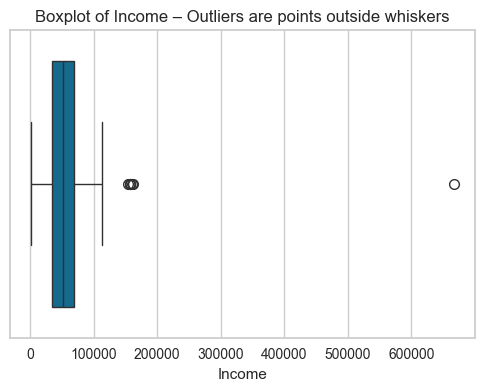

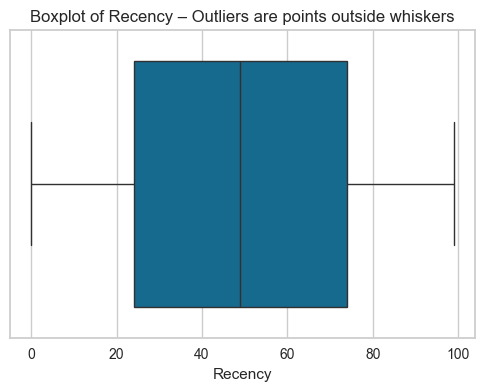

KeyError: 'Customer_For'

<Figure size 600x400 with 0 Axes>

In [50]:
# removing the outliers 
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ["Income", "Recency", "Customer_For", "Age", "spent"]

for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col} – Outliers are points outside whiskers")
    plt.show()


In [75]:
# filtering Age and Income outliers
data = data[ (data['Age']<90)   ]
data = data[(data['Income'] <600000)]
print(f"Total number of rows after removing outliers:{len(data)}")

Total number of rows after removing outliers:2212


In [79]:
print((data['Income'] == 600000))


0       True
1       True
2       True
3       True
4       True
        ... 
2235    True
2236    True
2237    True
2238    True
2239    True
Name: Income, Length: 2212, dtype: bool


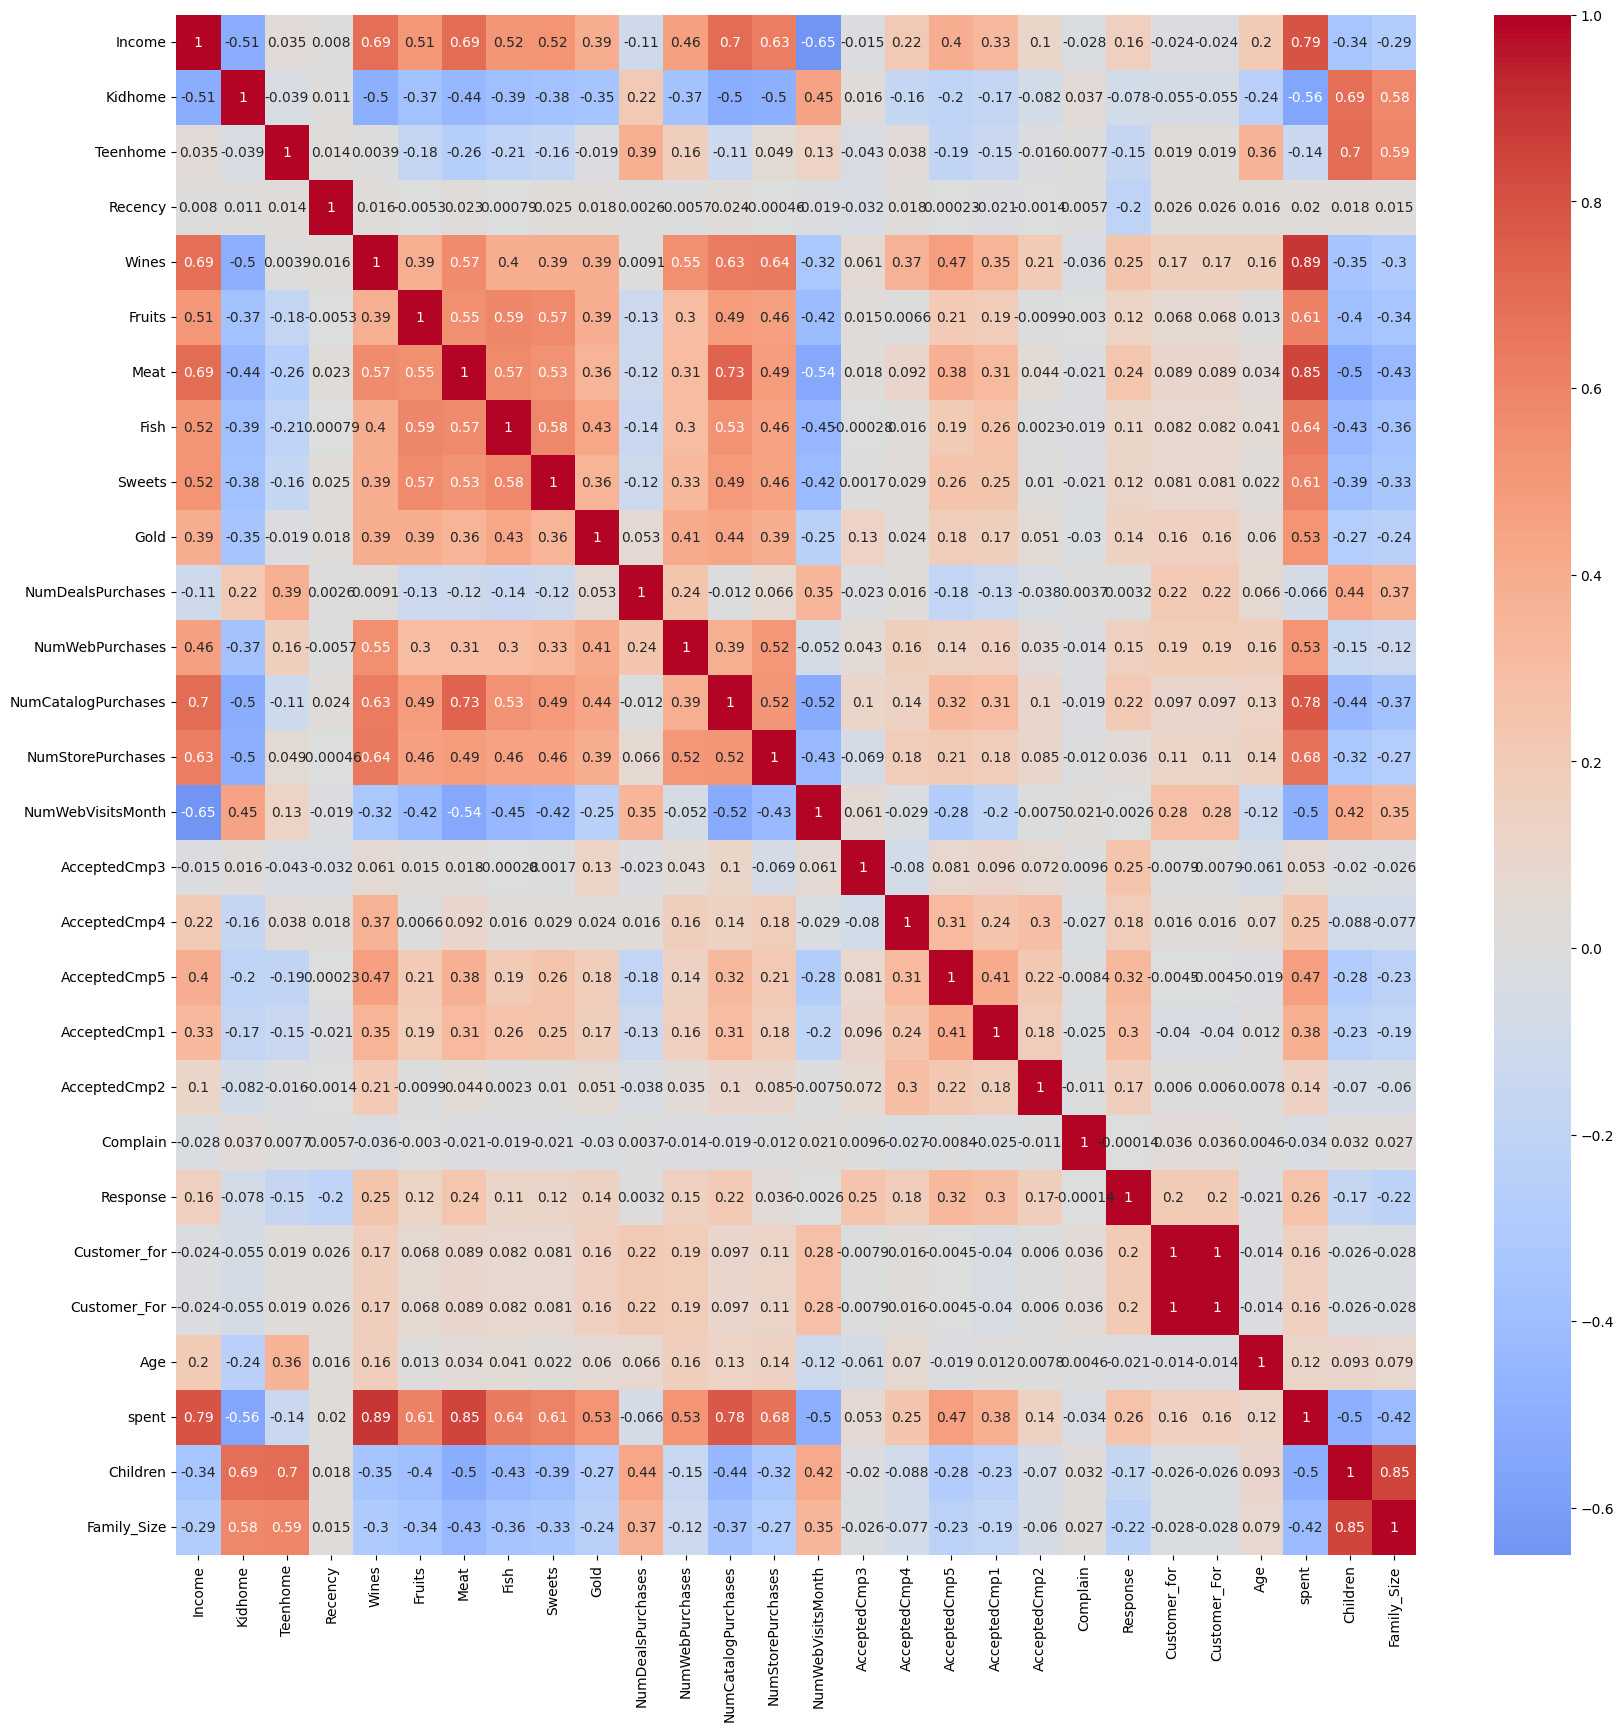

In [ ]:
# Lets check for correlation
num_data =data.drop(columns =['Education', 'Living_With'])
corrmat = num_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap="coolwarm", center=0)
plt.show()


### Data Preprocessing
In this section, perform preprocessing on the data for the process towards clustering.

The following steps were implemented to process the data:

Label encoding on categorical features
Feature scaling using standard scaler
Create DataFrame attributes for dimensionality reduction

In [52]:
# list of Categorical values
s =(data.dtypes == 'object')
object_col = list(s[s].index)
print(f"categorical columns : {object_col}")

categorical columns : ['Education', 'Living_With']


In [53]:


encoder = LabelEncoder()
for col in object_col:
    data[col] = encoder.fit_transform(data[col])

print("All categorical features are now numeric")
   


All categorical features are now numeric


In [54]:
print(data[object_col].head())   # Should show numeric values
print(data.dtypes[object_col])
print(data['Education'].dtype)
print(data['Education'].head(10))

   Education  Living_With
0          0            0
1          0            0
2          0            1
3          0            1
4          1            1
Education      int64
Living_With    int64
dtype: object
int64
0    0
1    0
2    0
3    0
4    1
5    1
6    0
7    1
8    1
9    1
Name: Education, dtype: int64


In [55]:
# scaling the featurs
temp = data.copy()
print(temp.dtypes)


Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Customer_for             int64
Age                      int64
spent                    int64
Living_With              int64
Children                 int64
Family_Size              int64
dtype: object


In [ ]:
temp = temp.drop(columns='Customer_For', errors='ignore')




In [58]:
col_del= ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
temp = temp.drop(col_del , axis=1)

scaler =StandardScaler()
scaler.fit(temp)
scaled_temp = pd.DataFrame(scaler.transform(temp) , columns =temp.columns )

In [59]:
scaled_temp.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_for,Age,spent,Living_With,Children,Family_Size
0,-0.894187,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,...,1.428553,2.504712,-0.554143,0.693232,1.529129,0.986443,1.675488,-1.348829,-1.264803,-1.758673
1,-0.894187,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,...,-1.125881,-0.571082,-1.169518,-0.131574,-1.188411,1.236801,-0.962358,-1.348829,1.405806,0.450009
2,-0.894187,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,...,1.428553,-0.229327,1.291982,-0.543978,-0.205155,0.318822,0.280250,0.741384,-1.264803,-0.654332
3,-0.894187,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,...,-0.760962,-0.912837,-0.554143,0.280829,-1.059945,-1.266777,-0.919224,0.741384,0.070501,0.450009
4,0.569268,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,...,0.333796,0.112428,0.061232,-0.131574,-0.951244,-1.016420,-0.307044,0.741384,0.070501,0.450009


### Dimensionality Reduction
There are numerous things to consider while determining the ultimate classification for this problem. These factors are essentially traits or features. Working with a large number of characteristics becomes increasingly difficult. Many of these qualities are connected and so redundant. As a result, the selected features will undergo dimensionality reduction before being passed to the classifier. Dimensionality reduction is the process of lowering the number of random variables examined to get a set of main variables.

Principal Component Analysis (PCA) is a technique for lowering the dimensionality of datasets like those used in this notebook, improving interpretability while minimizing information loss.

Steps in this section:

Dimensionality reduction with PCA
reduced DataFrame plotting
Dimensionality reduction with PCA

For this project, a dimension reduction of 3 was applied.

In [60]:
pca = PCA(n_components= 3)
pca.fit(scaled_temp)
PCA_temp = pd.DataFrame(pca.transform(scaled_temp), columns=(['col1','col2','col3']))
PCA_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,-6.412841e-18,2.769254,-5.805280,-2.442734,-0.741433,2.411733,7.238233
col2,2216.0,6.412841e-18,1.629160,-3.782101,-1.298096,-0.198898,1.143908,6.336882
col3,2216.0,-2.204414e-17,1.228073,-5.044767,-0.844535,-0.050797,0.861672,6.709724


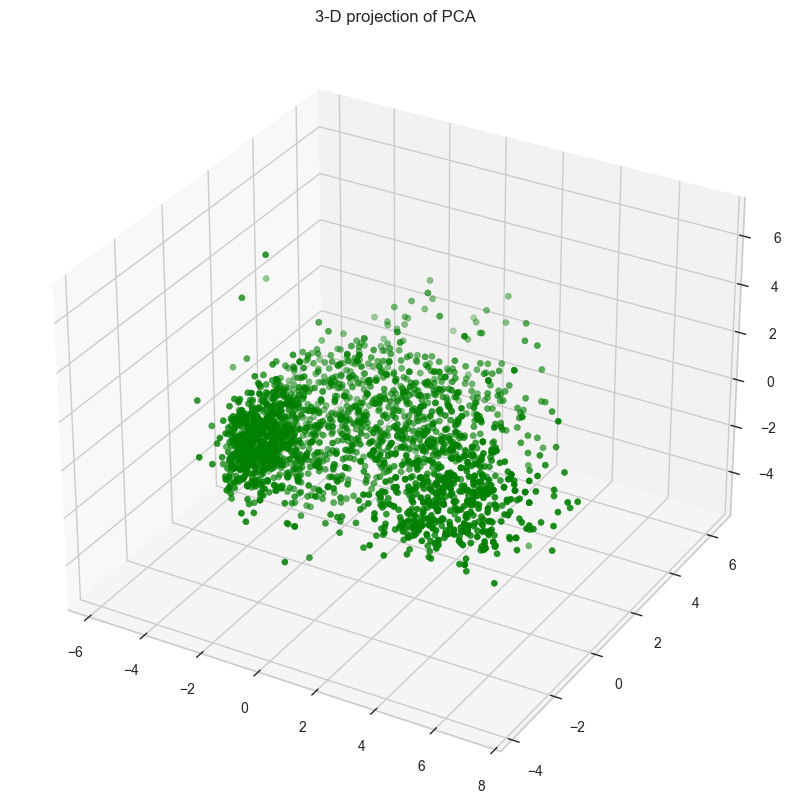

In [61]:
x = PCA_temp['col1']
y = PCA_temp['col2']
z = PCA_temp['col3']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z , c= 'green' , marker='o')
ax.set_title('3-D projection of PCA')
plt.show()

### Clusetring
Now that the attributes have been reduced to 3 dimensions, try clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical grouping method. This involves merging examples until the desired number of clusters is reached.

Steps involved in Clustering

Elbow Method to determine the number of clusters to be formed
Grouping via Agglomerative Clustering
Check the clusters formed through scatter plots


In [ ]:
import sys
print(sys.executable)

/Users/umaobbani/Documents/customer_segmentation/.venv/bin/python


Elbow Method to determine the number of clusters to be formed:


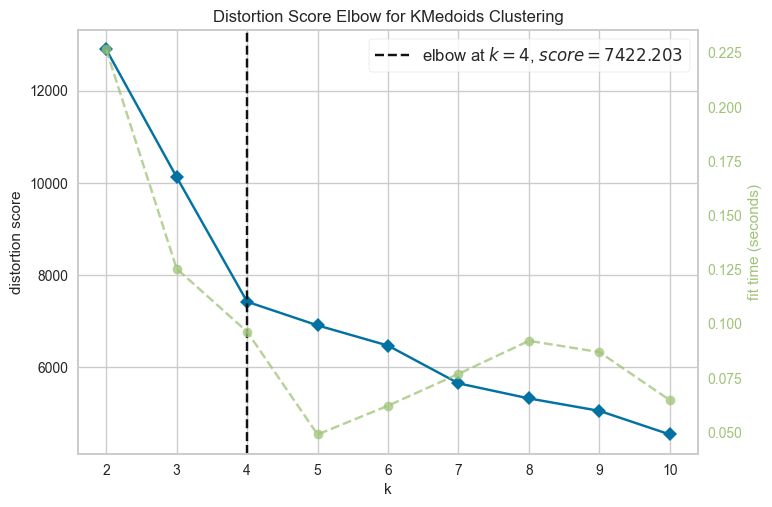

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import KElbowVisualizer



print("Elbow Method to determine the number of clusters to be formed:")
Elbow_M = KElbowVisualizer(KMedoids(), k= 10)
Elbow_M.fit(PCA_temp)
Elbow_M.show()

In [65]:
# initialize the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters= 4)

# fit model and predict cluster
yhat_AC = AC.fit_predict(PCA_temp)
PCA_temp["Clusters"] = yhat_AC

# add the Clusters feature to the original DataFrame
data["Clusters"] = yhat_AC

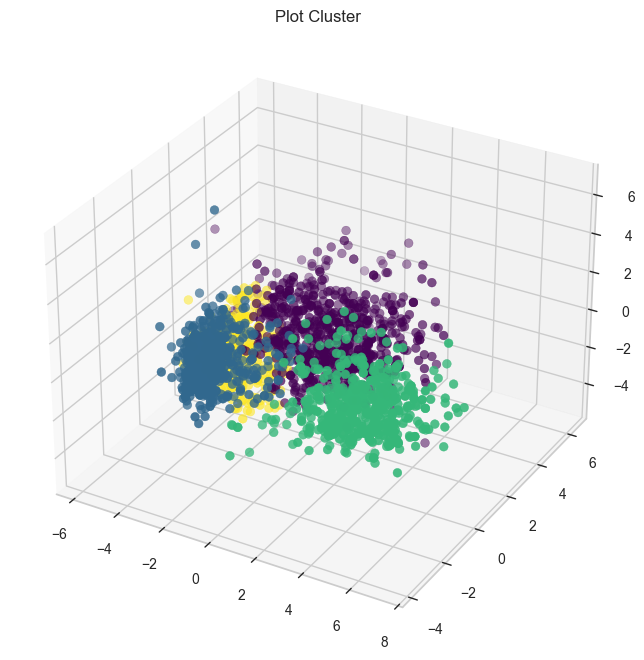

In [67]:
# plot clusters
fig = plt.figure(figsize= (10, 8))
ax = plt.subplot(111, projection= "3d", label= "bla")
ax.scatter(x, y, z, s= 40, c= PCA_temp["Clusters"], marker= 'o', cmap= 'viridis' )
ax.set_title("Plot Cluster")
plt.show()

### Evaluating Model
Because this model is unsupervised clustering. There are no features available to evaluate or rate this model. The purpose of this section is to study the patterns in the clusters that are formed and determine the nature of these cluster patterns.

For this reason, let's look at the data in the context of clusters through exploratory data analysis and draw conclusions.

First, lets look at the group distribution of clustering


/var/folders/wn/ct0g9r2x7j794g93g8f_jd280000gn/T/ipykernel_43403/248773628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x= data["Clusters"], palette= pal)


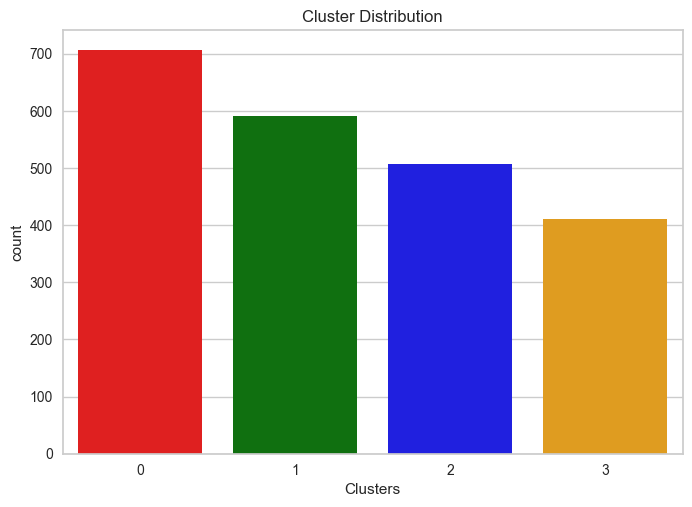

In [72]:
pal = ['red','green','blue','orange']
pl = sns.countplot(x= data["Clusters"], palette= pal)
pl.set_title("Cluster Distribution")
plt.show()

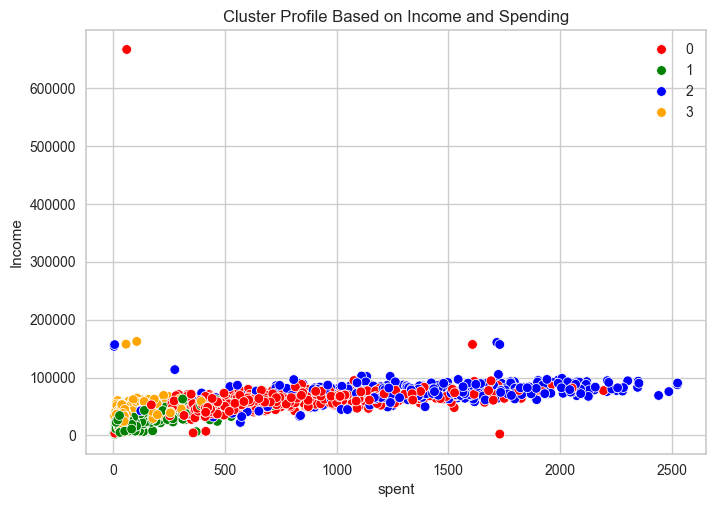

In [74]:
pl = sns.scatterplot(data= data,x= data["spent"], y= data["Income"], hue= data["Clusters"], palette= pal)
pl.set_title("Cluster Profile Based on Income and Spending")
plt.legend()
plt.show()

 ###Income vs Spend graph shows a cluster pattern
 

group 0: High spend & average Income
group 1: High spend & high income
group 2: Low spend & low income
group 3: High spend & low income
Next, let's look at the detailed distribution of clusters based on the various products in the data. Namely: Wine, Fruit, Meat, Fish, Candy, and Gold

/Users/umaobbani/Documents/customer_segmentation/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/umaobbani/Documents/customer_segmentation/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/umaobbani/Documents/customer_segmentation/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 63.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/wn/ct0g9r2x7j794g93g8f_jd280000gn/T/ipykernel_43403/1986195454.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` var

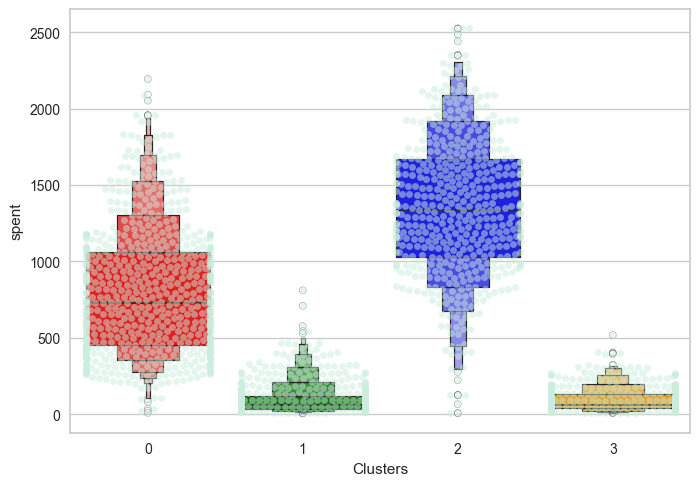

In [81]:
plt.figure()
pl = sns.swarmplot(x= data["Clusters"], y= data["spent"], color= "#CBEDDD", alpha=0.5)
pl = sns.boxenplot(x= data["Clusters"], y= data["spent"], palette= pal)
plt.show()

From the above plot, it is clearly visible that cluster 1 is the largest set of customers followed closely by cluster 0. Explore what each cluster spends on targeted marketing strategies.

Let's explore how promotions have performed in the past.

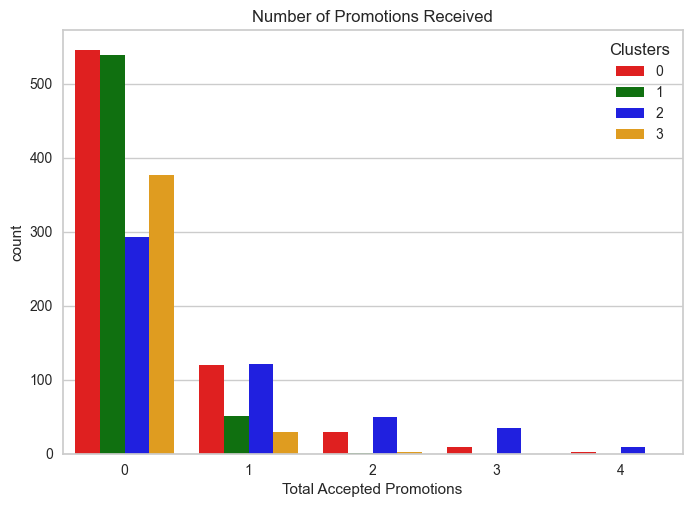

In [82]:
# create a feature to total the promotions received
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

# plot the total number of promotions received
plt.figure()
pl = sns.countplot(x= data["Total_Promos"], hue= data["Clusters"], palette= pal)
pl.set_title("Number of Promotions Received")
pl.set_xlabel("Total Accepted Promotions")
plt.show()

/var/folders/wn/ct0g9r2x7j794g93g8f_jd280000gn/T/ipykernel_43403/2193411280.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(y= data["NumDealsPurchases"], x= data["Clusters"], palette= pal)


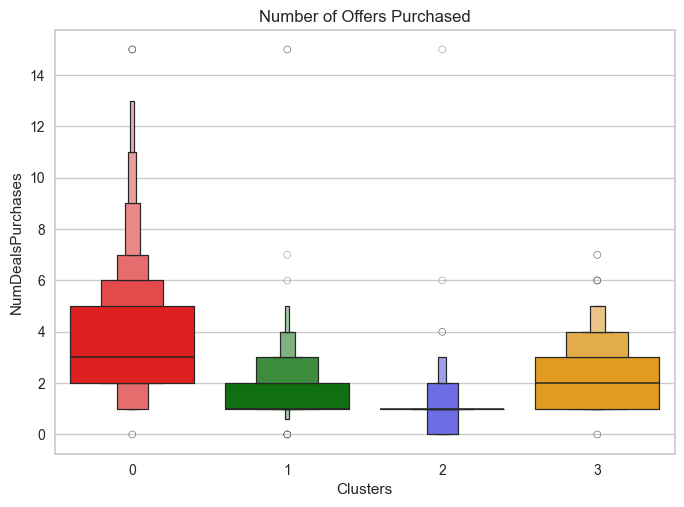

In [83]:
# plot the number of offers purchased
plt.figure()
pl = sns.boxenplot(y= data["NumDealsPurchases"], x= data["Clusters"], palette= pal)
pl.set_title("Number of Offers Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

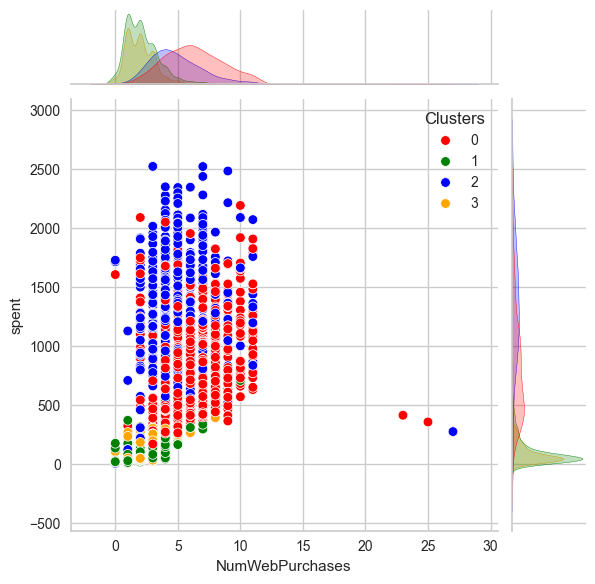

<Figure size 800x550 with 0 Axes>

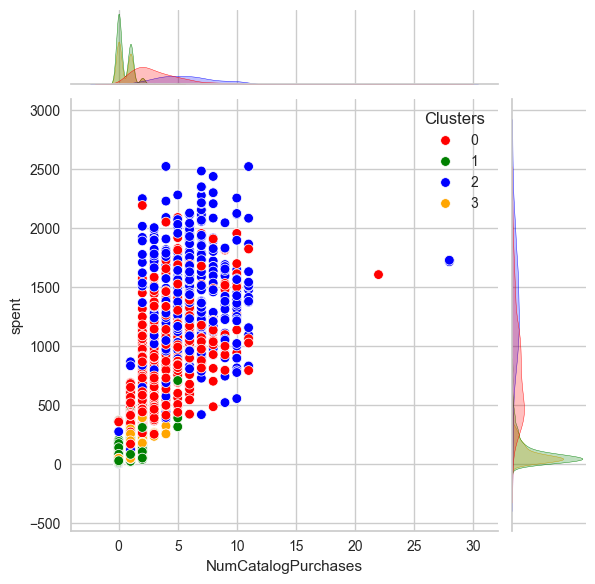

<Figure size 800x550 with 0 Axes>

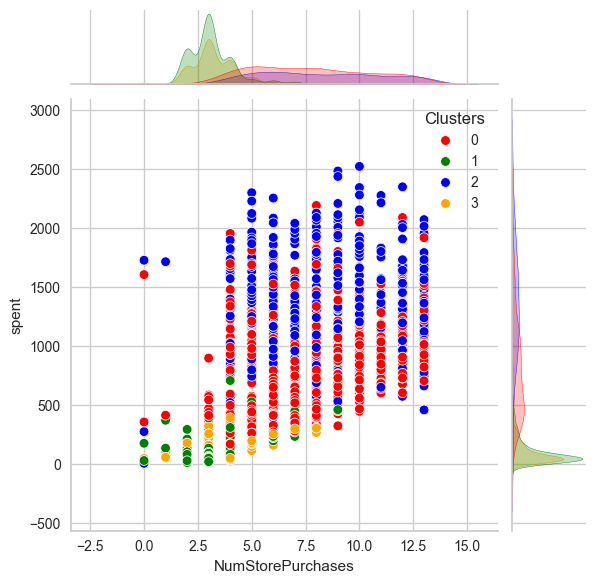

<Figure size 800x550 with 0 Axes>

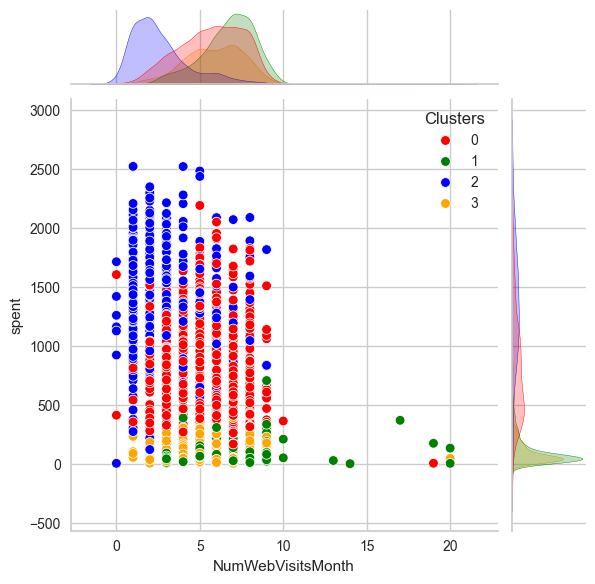

In [85]:
# for more details of purchasing style
Places = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x= data[i], y= data["spent"], hue= data["Clusters"], palette= pal)
    plt.show()

After establishing groups and analyzing their purchase habits. Let us examine who is in the clusters. Create a profile of the clusters formed and determine who are the primary customers and who require further attention from the retail store marketing staff.

To do so, plot many elements that represent a customer's personal traits within the context of the cluster they are in. We shall draw a conclusion based on the results.

In [95]:
cluster_profile = data.groupby("Clusters").agg({
    "Kidhome": ["mean", "max"],
    "Teenhome": ["mean", "max"],
    "Customer_for": ["mean", "min", "max"],
    "Age": ["mean", "min", "max"],
    "Children": ["mean", "max"],
    "Family_Size": ["mean", "min", "max"],
  
    "Education": lambda x: x.mode()[0],
    "Income": ["mean", "min", "max"]
}).reset_index()

# Flatten columns
cluster_profile.columns = ["_".join(col).strip("_") for col in cluster_profile.columns]

# Round numeric columns
numeric_cols = cluster_profile.select_dtypes(include="number").columns
cluster_profile[numeric_cols] = cluster_profile[numeric_cols].round(2)

print(cluster_profile)



   Clusters  Kidhome_mean  Kidhome_max  Teenhome_mean  Teenhome_max  \
0         0          0.29            2           0.96             2   
1         1          0.73            2           0.06             1   
2         2          0.02            1           0.01             1   
3         3          0.83            2           0.98             2   

   Customer_for_mean  Customer_for_min  Customer_for_max  Age_mean  Age_min  \
0             416.97                 0               699     59.64       36   
1             340.85                 2               697     48.69       29   
2             341.54                 1               698     56.64       30   
3             278.36                 0               693     59.96       40   

   Age_max  Children_mean  Children_max  Family_Size_mean  Family_Size_min  \
0       80           1.25             3              2.95                2   
1       85           0.78             2              2.37                1   
2       84    

Points to note:

The following information can be inferred about customers in various clusters.

Cluster 0:

They are definitely parents.
Maximum of 4 family members and minimum of 2.
Single Parent is a subset of this group.
Most have teenagers at home.
Relatively older.
Cluster 1:

*They are definitely not parents.

There is a maximum of only 2 members in the family.
Most are couples rather than single individuals.
Consists of all age ranges.
Group with high income.
Cluster 2:

Most of them are parents.
There is a maximum of 3 members in the family.
Most have one child (and not a teenager, usually).
Relatively younger.
Cluster 3:

They must be parents.
There is a maximum of 5 members in the family and a minimum of 2.
Most of them have teenagers at home.
Relatively older.
And groups with lower income.